In [14]:
import pandas as pd
import base64
from openai import OpenAI
import json
from pydantic import BaseModel
import cv2
import numpy as np
import fitz
from PIL import Image
from io import BytesIO
pd.set_option('display.max_columns', None)
from typing import Optional


import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

In [15]:
class ResearchPaperExtraction(BaseModel):
    subject: str
    participant_code: int
    variant: int
    answers_1: Optional[float]
    answers_2: Optional[float]
    answers_3: Optional[float]
    answers_4: Optional[float]
    answers_5: Optional[float]
    answers_6: Optional[float]
    answers_7: Optional[float]
    answers_8: Optional[float]
    answers_9: Optional[float]
    answers_10: Optional[float]
    replacement_1: Optional[float]
    replacement_2: Optional[float]
    replacement_3: Optional[float]
    replacement_4: Optional[float]
    replacement_5: Optional[float]
    replacement_6: Optional[float]
    replacement_7: Optional[float]
    replacement_8: Optional[float]
    replacement_9: Optional[float]
    replacement_10: Optional[float]

def encode_image(image):
# Convert the NumPy array to a PIL Image
    image = Image.fromarray(image)

    # Save the image to a BytesIO buffer in PNG format
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    buffer.seek(0)

    # Encode the PNG image to base64
    test_pic_bytes = buffer.getvalue()
    base64_encoded = base64.b64encode(test_pic_bytes).decode('utf-8')

    return base64_encoded

def extract_text_from_image(api_key, image, prompt):
    client = OpenAI(api_key=api_key)

    # Getting the base64 string
    base64_image = encode_image(image)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
        response_format={
                'type': 'json_schema',
                'json_schema':
                    {
                        "name": "whocares",
                        "schema": ResearchPaperExtraction.model_json_schema()
                    }},
    )

    json_response = json.loads(response.choices[0].message.content)
    return json_response

def transform_json_to_dataframe(parsed_json):
  df = pd.DataFrame([parsed_json])
  order = ['subject', 'participant_code', 'variant', 'answers_1', 'answers_2', 'answers_3', 'answers_4', 'answers_5', 'answers_6', 'answers_7', 'answers_8', 'answers_9', 'answers_10']
  df = df[order]
  rename_dict = {
    'subject': 'Предмет',
    'participant_code': 'Код участника',
    'variant': 'Вариант',
    'answers_1': 'Задание 1',
    'answers_2': 'Задание 2',
    'answers_3': 'Задание 3',
    'answers_4': 'Задание 4',
    'answers_5': 'Задание 5',
    'answers_6': 'Задание 6',
    'answers_7': 'Задание 7',
    'answers_8': 'Задание 8',
    'answers_9': 'Задание 9',
    'answers_10': 'Задание 10'
  }
  df.rename(columns=rename_dict, inplace=True)
  return df

def get_pic_from_pdf(pdf_path, index):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(index)
    pix = page.get_pixmap()
    pix.save(f'cur_temp_pic_{index}.png')
    template = cv2.imread(f'cur_temp_pic_{index}.png', 0)
    return template


def get_correct_answers(correct_answers_path):
    correct_answers = pd.read_excel(correct_answers_path)
    for col in correct_answers.columns:
        if col != 'Вариант':
            correct_answers[col] = correct_answers[col].astype(str)
            correct_answers[col] = correct_answers[col].apply(lambda x: x.replace(',', '.'))
            correct_answers[col] = correct_answers[col].astype(float)
            correct_answers[col] = correct_answers[col].astype(str)
    correct_answers['Вариант'] = correct_answers['Вариант'].astype(str)
    correct_answers.rename(columns={1: "Правильный ответ 1", 2: "Правильный ответ 2", 3: "Правильный ответ 3", 4: "Правильный ответ 4", 5: "Правильный ответ 5", 6: "Правильный ответ 6", 7: "Правильный ответ 7", 8: "Правильный ответ 8", 9: "Правильный ответ 9", 10: "Правильный ответ 10"}, inplace=True)
    return correct_answers

def postprocess_raw_output(df_global_fin, correct_answers):
    df_global_fin['Предмет'] = df_global_fin['Предмет'].str.upper()
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(int)
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(str)
    for i in range(1, 11):
        df_global_fin[f'Задание {i}'] = df_global_fin[f'Задание {i}'].astype(float)
        df_global_fin[f'Замена {i}'] = df_global_fin[f'Замена {i}'].astype(float)
    for col in df_global_fin.columns:
        df_global_fin[col] = df_global_fin[col].astype(str)

    total_df = pd.merge(df_global_fin, correct_answers, on="Вариант", how="left")

    return total_df

def check_answers(total_df):

    scores_dict = {
    1: 0.5,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1.5
    }

    for i in range(1, 11):
        total_df[f'Верно {i}'] = (total_df[f'Правильный ответ {i}'] == total_df[f'Ответ {i}']).replace(True, 'Верно').replace(False, 'Неверно')
        total_df[f'Начисленные баллы {i}'] = (total_df[f'Правильный ответ {i}'] == total_df[f'Ответ {i}']).replace(True, 'Верно').replace(False, 'Неверно').apply(lambda x: scores_dict[i] if x == 'Верно' else 0)

    total_df['Начисленные баллы сумма'] = total_df[[f'Начисленные баллы {i}' for i in range(1, 11)]].sum(axis=1)

    return total_df

def final_styling(total_df):
    reorder_cols_list = ['Предмет', 'Код участника', 'Вариант', 'Начисленные баллы сумма']
    for i in range(1, 11):  
        reorder_cols_list.append(f'Ответ {i}')
        reorder_cols_list.append(f'Правильный ответ {i}')
        reorder_cols_list.append(f'Начисленные баллы {i}')
    total_df = total_df[reorder_cols_list]

    return total_df

def run_pipeline(pdf_path, answers_path,api_key):
    pdf_document = fitz.open(pdf_path)
    num_pages = pdf_document.page_count

    df_global = pd.DataFrame()
    for i in range(num_pages):
        cur_pic = get_pic_from_pdf(pdf_path, i)
        parsed_json = extract_text_from_image(api_key, cur_pic)
        df_current = transform_json_to_dataframe(parsed_json)
        df_global = pd.concat([df_global, df_current]).reset_index(drop=True)

    correct_answers = get_correct_answers(answers_path)
    df_global_processed = postprocess_raw_output(df_global, correct_answers)
    df_global_answers = check_answers(df_global_processed)
    df_global_styled = final_styling(df_global_answers)
    
    return df_global_styled

In [16]:
# api_key = ''
# pdf_path = "Сканы бланков ответов.PDF"

# pdf_path = 'scans.pdf'
# answers_path = 'answers.xlsx'
# df_global_fin_raw = run_pipeline(pdf_path, answers_path, api_key)

In [17]:

pdf_path = 'test_pics/Сканы бланков ответов (новый бланк).pdf'
cur_pic = get_pic_from_pdf(pdf_path, 1)

In [18]:
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(cur_pic)
plt.axis('off')  # Hide the axis
plt.show()

C:\Users\zamko\AppData\Local\Temp\ipykernel_20976\968789529.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [19]:
import streamlit as st
import pandas as pd
import fitz
import cv2
from io import BytesIO
from PIL import Image
import base64
from openai import OpenAI
from pydantic import BaseModel
import json
import numpy as np
import traceback
from typing import Optional

import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

promt = """"You are tasked with extracting information from an image of a completed exam answer sheet and converting it into a structured JSON format. The answer sheet has the following structure:

Top Section:

Document Title: Labeled as "БЛАНК ОТВЕТОВ."
Subject Name: Handwritten in a grid labeled "МАТЕМАТИКА."
Participant Code: A field containing four cells where numbers are written.
Version Number: A field containing four cells where numbers are written.
Instructions: Indicates that answers can be integers or finite decimal fractions with 1-2 decimal places. It specifies that units of measurement and periods should not be included after the answer.
Example: The example answer "-0,9" is provided.
Middle Section:

Filling Instructions: Explains that filling should be done using a black gel or capillary pen with digits of a specific standard. Acceptable symbols are listed as: ", -1234567890."
Example of Valid Symbols: Includes symbols such as ", -1234567890."
Main Section: Divided into two large columns:

Left Column: "Ответы к заданиям"

Numbered from 1 to 10.
Each question is accompanied by a grid of cells to record the answer.
Examples of filled answers:
№1: "275"
№2: "38"
№3: "14"
№4: "3478"
№5: "102"
№6: "3"
№7: "0,5"
№8: "18"
Right Column: "Замена ошибочных ответов на задания"

Numbered similarly to the left column (1–10).
Intended for recording corrected answers for mistakes.
Examples of corrections:
№1: Corrected answer "-275."
№7: Corrected answer "-3."
Your task:

Extract all the information from the described answer sheet and format it in a JSON structure.
Ensure the JSON includes all relevant details such as subject name, participant code, version number, and both the answers and corrections for questions.
Example JSON Structure:
{
  "subject_name": "МАТЕМАТИКА",
  "participant_code": "1234",
  "version_number": "5678",
  "answer_1": "275",
  "answer_2": "38",
  "answer_3": "14",
  "answer_4": "3478",
  "answer_5": "102",
  "answer_6": "3",
  "answer_7": "0,5",
  "answer_8": "18",
  "answer_9": "",
  "answer_10": "",
  "correction_1": "-275",
  "correction_2": "",
  "correction_3": "",
  "correction_4": "",
  "correction_5": "",
  "correction_6": "",
  "correction_7": "-3",
  "correction_8": "",
  "correction_9": "",
  "correction_10": ""
}"""

class ResearchPaperExtraction(BaseModel):
    subject_name: str
    participant_code: int
    version_number: int
    answer_1: Optional[float]
    answer_2: Optional[float]
    answer_3: Optional[float]
    answer_4: Optional[float]
    answer_5: Optional[float]
    answer_6: Optional[float]
    answer_7: Optional[float]
    answer_8: Optional[float]
    answer_9: Optional[float]
    answer_10: Optional[float]
    correction_1: Optional[float]
    correction_2: Optional[float]
    correction_3: Optional[float]
    correction_4: Optional[float]
    correction_5: Optional[float]
    correction_6: Optional[float]
    correction_7: Optional[float]
    correction_8: Optional[float]
    correction_9: Optional[float]
    correction_10: Optional[float]

def transform_json_to_dataframe(parsed_json):
  df = pd.DataFrame([parsed_json])
  order = ['subject_name', 'participant_code', 'version_number', 'answer_1', 'answer_2', 'answer_3', 'answer_4', 'answer_5', 'answer_6', 'answer_7', 'answer_8', 'answer_9', 'answer_10', 'correction_1', 'correction_2', 'correction_3', 'correction_4', 'correction_5', 'correction_6', 'correction_7', 'correction_8', 'correction_9', 'correction_10']
  df = df[order]
  rename_dict = {
    'subject_name': 'Предмет',
    'participant_code': 'Код участника',
    'version_number': 'Вариант',
    'answer_1': 'Задание 1',
    'answer_2': 'Задание 2',
    'answer_3': 'Задание 3',
    'answer_4': 'Задание 4',
    'answer_5': 'Задание 5',
    'answer_6': 'Задание 6',
    'answer_7': 'Задание 7',
    'answer_8': 'Задание 8',
    'answer_9': 'Задание 9',
    'answer_10': 'Задание 10',
    'correction_1': 'Замена 1',
    'correction_2': 'Замена 2',
    'correction_3': 'Замена 3',
    'correction_4': 'Замена 4',
    'correction_5': 'Замена 5',
    'correction_6': 'Замена 6',
    'correction_7': 'Замена 7',
    'correction_8': 'Замена 8',
    'correction_9': 'Замена 9',
    'correction_10': 'Замена 10'
  }
  df.rename(columns=rename_dict, inplace=True)
  return df

def check_answers(total_df):

    scores_dict = {
    1: 0.5,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1.5
    }

    for i in range(1, 11):
        total_df[f'Начисленные баллы {i}'] = ((total_df[f'Правильный ответ {i}'] == total_df[f'Задание {i}']) | (total_df[f'Правильный ответ {i}'] == total_df[f'Замена {i}'])).replace(True, 'Верно').replace(False, 'Неверно').apply(lambda x: scores_dict[i] if x == 'Верно' else 0)

    total_df['Начисленные баллы сумма'] = total_df[[f'Начисленные баллы {i}' for i in range(1, 11)]].sum(axis=1)

    return total_df

def final_styling(total_df):
    reorder_cols_list = ['Предмет', 'Код участника', 'Вариант']
    for i in range(1, 11):  
        reorder_cols_list.append(f'Задание {i}')
        reorder_cols_list.append(f'Замена {i}')

    for i in range(1, 11):
        reorder_cols_list.append(f'Начисленные баллы {i}')
    reorder_cols_list.append('Начисленные баллы сумма')
    total_df = total_df[reorder_cols_list]

    for i in range(1, 11):
        total_df.loc[:, f'Задание {i}'] = total_df[f'Замена {i}'].where(total_df[f'Замена {i}'] != 'nan', total_df[f'Задание {i}'])
        total_df = total_df.drop(columns=[f'Замена {i}'])

    for col in total_df.columns:
        total_df[col] = total_df[col].replace('nan', '')

    return total_df


def save_to_excel(df_global_styled, file_name="Formatted_Data.xlsx"):
    columns = ["Предмет", "Код участника", "Вариант", "Задание 1", "Задание 2", "Задание 3", "Задание 4", "Задание 5", "Задание 6", "Задание 7", "Задание 8", "Задание 9", "Задание 10", "Начисленные баллы 1", "Начисленные баллы 2", "Начисленные баллы 3", "Начисленные баллы 4", "Начисленные баллы 5", "Начисленные баллы 6", "Начисленные баллы 7", "Начисленные баллы 8", "Начисленные баллы 9", "Начисленные баллы 10"]

    # Save to Excel with formatting
    wb = Workbook()
    ws = wb.active
    ws.title = "Общая таблица"

    # Write the header
    header = ["Предмет", "Код участника", "Вариант", "Ответы", None, None, None, None, None, None, None, None, None, "Баллы", None, None, None, None, None, None, None, None, None, "Всего"]
    ws.append(header)
    ws.merge_cells(start_row=1, start_column=4, end_row=1, end_column=13)
    ws.merge_cells(start_row=1, start_column=14, end_row=1, end_column=23)
    ws.merge_cells(start_row=1, start_column=1, end_row=3, end_column=1)
    ws.merge_cells(start_row=1, start_column=2, end_row=3, end_column=2)
    ws.merge_cells(start_row=1, start_column=3, end_row=3, end_column=3)
    ws.merge_cells(start_row=1, start_column=24, end_row=2, end_column=24)

    # Write the subheader
    ws.append(columns)

    # Write the data
    for row in dataframe_to_rows(df_global_styled, index=False, header=False):
        ws.append(row)

    # Align headers
    for cell in ws[1]:
        cell.alignment = Alignment(horizontal="center", vertical="center")

    # Create a border for the entire dataframe
    thin_border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))
    for row in ws.iter_rows(min_row=1, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
        for cell in row:
            cell.border = thin_border

    # Make the first three rows bold
    for row in ws.iter_rows(min_row=1, max_row=3):
        for cell in row:
            cell.font = Font(bold=True)

    for col in range(4, 14):
        ws.merge_cells(start_row=2, start_column=col, end_row=3, end_column=col)

    # Save the file
    wb.save(file_name)

In [20]:
api_key = ''
pdf_path = 'test_pics/Сканы бланков ответов (новый бланк).pdf'

pdf_document = fitz.open(pdf_path)
num_pages = pdf_document.page_count

df_global = pd.DataFrame()
for i in range(num_pages):
    cur_pic = get_pic_from_pdf(pdf_path, i)
    parsed_json = extract_text_from_image(api_key, cur_pic, promt)
    df_current = transform_json_to_dataframe(parsed_json)
    df_global = pd.concat([df_global, df_current]).reset_index(drop=True)  


C:\Users\zamko\AppData\Local\Temp\ipykernel_20976\30441850.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_global = pd.concat([df_global, df_current]).reset_index(drop=True)
C:\Users\zamko\AppData\Local\Temp\ipykernel_20976\30441850.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_global = pd.concat([df_global, df_current]).reset_index(drop=True)
C:\Users\zamko\AppData\Local\Temp\ipykernel_20976\30441850.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or a

In [33]:


answers_path = 'answers.xlsx'


correct_answers = get_correct_answers(answers_path)
df_global_processed = postprocess_raw_output(df_global, correct_answers)
df_global_answers = check_answers(df_global_processed)
df_global_styled = final_styling(df_global_answers)

df_global_styled = df_global_styled.rename(columns={'Начисленные баллы сумма': ''})

temp_df = pd.DataFrame([['Предмет', 'Код участника', 'Вариант', "Задание 1", "Задание 2", "Задание 3", "Задание 4", "Задание 5", "Задание 6", "Задание 7", "Задание 8", "Задание 9", "Задание 10", 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1.5, 10]], columns=df_global_styled.columns)
temp_df.columns = df_global_styled.columns
df_global_styled = pd.concat([temp_df, df_global_styled], ignore_index=True)

In [34]:
df_global_styled

,Предмет,Код участника,Вариант,Задание 1,Задание 2,Задание 3,Задание 4,Задание 5,Задание 6,Задание 7,Задание 8,Задание 9,Задание 10,Начисленные баллы 1,Начисленные баллы 2,Начисленные баллы 3,Начисленные баллы 4,Начисленные баллы 5,Начисленные баллы 6,Начисленные баллы 7,Начисленные баллы 8,Начисленные баллы 9,Начисленные баллы 10,
0,Предмет,Код участника,Вариант,Задание 1,Задание 2,Задание 3,Задание 4,Задание 5,Задание 6,Задание 7,Задание 8,Задание 9,Задание 10,0.5,1,1,1,1,1,1,1,1,1.5,10.0
1,МАТЕМАТИКА,1306,2,-280.0,37.5,13.0,3479.0,24.5,102.0,-3.0,0.5,18.5,,0.0,1,0,0,1,1,1,0,0,0.0,4.0
2,МАТЕМАТИКА,1299,2,275.0,37.0,15.0,3478.0,24.5,102.0,-3.0,-0.5,17.0,0.25,0.0,0,0,1,1,1,1,1,0,0.0,5.0
3,МАТЕМАТИКА,1293,2,280.0,38.0,14.0,3478.0,24.5,102.0,3.0,-0.5,17.05,0.75,0.0,0,1,1,1,1,0,1,0,0.0,5.0
4,МАТЕМАТИКА,1285,2,-275.0,38.0,14.0,3478.0,102.0,3.0,-3.0,18.0,,,0.5,0,1,1,0,0,1,0,0,0.0,3.5
5,МАТЕМАТИКА,1278,2,-235.0,37.5,14.0,3508.0,24.05,102.0,3.0,-0.5,18.0,-1.0,0.0,1,1,0,0,1,0,1,0,0.0,4.0
6,МАТЕМАТИКА,1263,2,275.0,37.5,14.0,3478.0,24.5,,-3.0,0.5,,,0.0,1,1,1,1,0,1,0,0,0.0,5.0
7,МАТЕМАТИКА,1256,2,-273.0,37.0,24.0,3478.0,24.5,102.0,-3.0,-0.55,18.0,,0.0,0,0,1,1,1,1,0,0,0.0,4.0
8,МАТЕМАТИКА,1251,2,275.0,37.5,14.0,3479.0,24.5,103.0,-3.0,-1.0,17.5,-0.25,0.0,1,1,0,1,0,1,0,1,0.0,5.0
9,МАТЕМАТИКА,1244,2,275.0,40.5,14.0,3578.0,34.5,102.0,3.0,-0.5,17.5,,0.0,0,1,0,0,1,0,1,1,0.0,4.0


In [35]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

def save_to_excel(df_global_styled, file_name="Formatted_Data.xlsx"):
    columns = ["Предмет", "Код участника", "Вариант", "Задание 1", "Задание 2", "Задание 3", "Задание 4", "Задание 5", "Задание 6", "Задание 7", "Задание 8", "Задание 9", "Задание 10", "Начисленные баллы 1", "Начисленные баллы 2", "Начисленные баллы 3", "Начисленные баллы 4", "Начисленные баллы 5", "Начисленные баллы 6", "Начисленные баллы 7", "Начисленные баллы 8", "Начисленные баллы 9", "Начисленные баллы 10"]

    # Save to Excel with formatting
    wb = Workbook()
    ws = wb.active
    ws.title = "Общая таблица"

    # Write the header
    header = ["Предмет", "Код участника", "Вариант", "Ответы", None, None, None, None, None, None, None, None, None, "Баллы", None, None, None, None, None, None, None, None, None, "Всего"]
    ws.append(header)
    ws.merge_cells(start_row=1, start_column=4, end_row=1, end_column=13)
    ws.merge_cells(start_row=1, start_column=14, end_row=1, end_column=23)
    ws.merge_cells(start_row=1, start_column=1, end_row=3, end_column=1)
    ws.merge_cells(start_row=1, start_column=2, end_row=3, end_column=2)
    ws.merge_cells(start_row=1, start_column=3, end_row=3, end_column=3)
    ws.merge_cells(start_row=1, start_column=24, end_row=2, end_column=24)

    # Write the subheader
    ws.append(columns)

    # Write the data
    for row in dataframe_to_rows(df_global_styled, index=False, header=False):
        ws.append(row)

    # Align headers
    for cell in ws[1]:
        cell.alignment = Alignment(horizontal="center", vertical="center")

    # Create a border for the entire dataframe
    thin_border = Border(left=Side(style='thin'), right=Side(style='thin'), top=Side(style='thin'), bottom=Side(style='thin'))
    for row in ws.iter_rows(min_row=1, max_row=ws.max_row, min_col=1, max_col=ws.max_column):
        for cell in row:
            cell.border = thin_border

    # Make the first three rows bold
    for row in ws.iter_rows(min_row=1, max_row=3):
        for cell in row:
            cell.font = Font(bold=True)

    for col in range(4, 14):
        ws.merge_cells(start_row=2, start_column=col, end_row=3, end_column=col)

    # Save the file
    wb.save(file_name)

# temp_df = pd.DataFrame([['Предмет', 'Код участника', 'Вариант', "Задание 1", "Задание 2", "Задание 3", "Задание 4", "Задание 5", "Задание 6", "Задание 7", "Задание 8", "Задание 9", "Задание 10", 0.5, 1, 1, 1, 1, 1, 1, 1, 1, 1.5, 10]], columns=df_global_styled.columns)
# temp_df.columns = df_global_styled.columns
# df_global_styled = pd.concat([temp_df, df_global_styled], ignore_index=True)

save_to_excel(df_global_styled)


In [1]:
import pandas as pd
import base64
from openai import OpenAI
import json
from pydantic import BaseModel
import cv2
import numpy as np
import fitz
from PIL import Image
from io import BytesIO
pd.set_option('display.max_columns', None)
from typing import Optional


import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Alignment, Border, Side, Font

In [35]:
def get_contours(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 100 < w < 150 and 100 < h < 200:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

In [46]:
# image_path = 'test_pics/empty_example_cells.jpg'
# contours_valid, output = get_contours(image_path)

# plt.figure(figsize=(20, 20))  # Increase the size of the plot
# plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()


In [97]:
def visualize_contours(contours, img_path):
    output = cv2.imread(img_path)
    # Бинаризация (порог)
    _, thresh = cv2.threshold(output, 190, 255, cv2.THRESH_BINARY)

    # Морфологическая операция "closing", чтобы убрать разрывы
    kernel = np.ones((1,1), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Можно слегка «размыть» (blur), если хочется чуть более сглаженные края
    blur = cv2.GaussianBlur(closing, (1,1), 0)

    x, y, w, h = cv2.boundingRect(contours)
    roi = output[y:y+h, x:x+w]
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    plt.show()

def get_aligned_pic(template_path, filled_form_path):

    template = cv2.imread(template_path, 0)
    filled_form = cv2.imread(filled_form_path, 0)  # Заполненный бланк

    # decrease size of images
    filled_form = cv2.resize(filled_form, (0, 0), fx=0.3, fy=0.3)

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled_form, None)

    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Используем лучшие сопоставления
    good_matches = matches[:50]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape
    aligned_image = cv2.warpPerspective(filled_form, matrix, (w, h))

    # Сохранение результата
    cv2.imwrite('aligned_form.jpg', aligned_image)

    return aligned_image

def align_images(template_path, filled_form_path):
    """
    Сопоставляет img_to_align с img_reference при помощи ORB и гомографии.
    Возвращает выровненное изображение, матрицу гомографии и др.
    """

    img_reference = cv2.imread(template_path)
    img_to_align = cv2.imread(filled_form_path)  # Заполненный бланк

    # Переводим в градиент
    gray_ref = cv2.cvtColor(img_reference, cv2.COLOR_BGR2GRAY)
    gray_align = cv2.cvtColor(img_to_align, cv2.COLOR_BGR2GRAY)

    # Инициализируем ORB
    orb = cv2.ORB_create(5000)

    # Ищем ключевые точки и вычисляем дескрипторы
    kp_ref, des_ref = orb.detectAndCompute(gray_ref, None)
    kp_align, des_align = orb.detectAndCompute(gray_align, None)

    # Ищем совпадения дескрипторов (матчинг)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des_ref, des_align)

    # Сортируем совпадения по возрастанию расстояния
    matches = sorted(matches, key=lambda x: x.distance)

    # Если точек мало, есть риск плохого выравнивания
    good_matches = matches[:50]  # берем топ-50 совпадений или больше

    # Берём соответствующие точки
    ref_pts = np.float32([kp_ref[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    align_pts = np.float32([kp_align[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    # Находим гомографию
    H, mask = cv2.findHomography(align_pts, ref_pts, cv2.RANSAC, 5.0)

    # Применяем перспективное преобразование
    height, width, channels = img_reference.shape
    aligned_img = cv2.warpPerspective(img_to_align, H, (width, height))

    cv2.imwrite('aligned_form.jpg', aligned_img)

    # Рисуем совпадения
    img_matches = cv2.drawMatches(
        img_reference, kp_ref,      # первое изображение и его ключевые точки
        img_to_align, kp_align,     # второе изображение и его ключевые точки
        good_matches,               # сами совпадения (список объектов DMatch)
        None,                       # выходное изображение (можно указать None — тогда создаст новое)
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    #  Plot img_reference and aligned_img on one plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_reference)
    plt.title('img_reference')
    plt.subplot(1, 2, 2)
    plt.imshow(aligned_img)
    plt.title('aligned_img')
    plt.show()

    # Показываем результат
    plt.imshow(img_matches)
    plt.show()

    return aligned_img, H

In [1]:
# contours, output = get_contours("test_pics/empty_example_cells.jpg")
# aligned_pic = align_images("test_pics/empty_example_no_cels.jpg", "page-1.jpg")
# for contour in contours:
#     visualize_contours(contour, 'aligned_form.jpg')

In [67]:
img_reference = cv2.imread("test_pics/empty_example.jpg", 0)
img_to_align = cv2.imread("page-1.jpg", 0)  # Заполненный бланк


In [71]:
cv2.cvtColor(img_reference, cv2.COLOR_BGR2GRAY)

error: OpenCV(4.10.0) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x46dff480::Set<1,-1,-1>,struct cv::impl::A0x46dff480::Set<0,2,5>,4>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


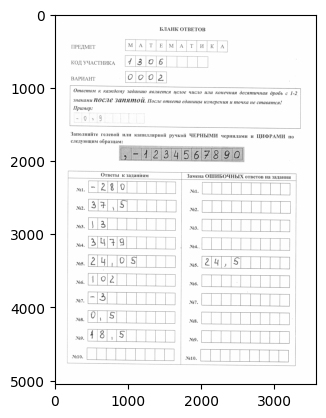

In [70]:
plt.imshow(img_to_align, cmap='gray')
plt.show()



In [58]:
def get_pic_from_pdf(pdf_path, index):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(index)
    # Устанавливаем разрешение
    dpi = 300
    pix = page.get_pixmap(dpi=300)
    pix.save(f'cur_temp_pic_{index}.png')
    template = cv2.imread(f'cur_temp_pic_{index}.png', 0)
    return template


api_key = ''
pdf_path = 'test_pics/Сканы бланков ответов (новый бланк).pdf'

pdf_document = fitz.open(pdf_path)
num_pages = pdf_document.page_count

df_global = pd.DataFrame()
for i in range(num_pages):
    cur_pic = get_pic_from_pdf(pdf_path, i)